# VIOLATION OF BELL-CHSH INEQUALITY USING QISKIT


#### *Author*: Juan Francisco Martín and Júlia Barberà, 6th October of 2022

This notebook uses the code from a qiskit tutorial that can be found at https://qiskit.org/textbook/ch-demos/chsh.html. The aim of this work is to demonstrate the violation of Bell-CHSH inequality using a quanutm circuit. Bell stated that any theory involving local hidden variables could be experimentally ruled out. In this section we are going to see how, and we will run a real experiment that demonstrates so. 


Take into account that qiskit uses Alice and Bob to explain the simulations. However, we will extrapolate the example to our paper where we are substituing Alice and Bob by two entangled interacting protons  (Sakai, H., et al. "Spin correlations of strongly interacting massive fermion pairs as a test of Bell’s inequality." Physical review letters 97.15 (2006): 150405.)

## The CHSH inequality 

We have two entangled protons which have been created from the decay of the ${}^2$H $+{}^1$H $\rightarrow$ ${}^2$He reaction. This beam is sent to a magnetic spectrometer that selects the protons that have a determinate momentum and the "event-ready" detector tracks the particles after they have exit the SMART. Finally, the EPOL polarimeter measures the directional asymmetries caused by the scattering, providing information regarding the spin-correlation between the protons. We can think as the axis of the measurements as the different basis in which the protons are measured. The following picture shows a representation of the polarimeters with the 4 detectors. 

For arbitrary directions (basis) $\vec{a}$, $\vec{b}$, $\vec{a'}$ and $\vec{b'}$, the CHSH spin correlation function is bounded by 2 as
<br>
<center>$|C(\vec{a},\vec{b})- C(\vec{a},\vec{b'})|+|C(\vec{a'},\vec{b})+ C(\vec{a'},\vec{b'})|\leq 2,$ 
<br>
    
as it has been demonstrated in the paper.
    
However, when we consider an entangled system instead we will see that this inequality is violated. 

In [1]:
#import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Set devices, if using a real device
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_quito')

In [3]:
sim = Aer.get_backend('aer_simulator')

Suppose that the second proton uses the computational basis $Z$ and the $X$ basis for his two detectors($L_2$ and $R_2$). For the first proton, we will consider orthogonal bases but varying the angle of them between $0$ rad and $\pi$ rad with respect the second proton's bases as Sakai et al. do in their paper.  

Therefore, the quantum circuit is structured as follows. The first thing we need to implement are the maximally entangled states, which are given by the Bell states 

$|{\phi^{\pm}}\rangle = \frac{1}{\sqrt{2}}(|{00}\rangle\pm|{11}\rangle) 
\quad\text{and}\quad
|{\psi^{\pm}}\rangle = \frac{1}{\sqrt{2}}(|{01}\rangle\pm|{10}\rangle),
$

as we need the highest purity. We can construct them by using a $H$ and a $X$ quantum logic gates. Then, by implementing a $R_y(\phi)$ gate we can simulate the measurement of that performs the first proton in its basis. Finally, we do the measurement in the computational basis ($|{0}\rangle$ and $|{1}\rangle$) or the $X$ basis for the second proton to obtain the expectation value for each angle. The circuits used to compute measurements which give us the expectation value of the spin-correlation function are shown in the figure below. 

In [4]:
def make_chsh_circuit(phi_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in phi_vec)
    
        Args:
            phi_vec (list): list of values of angles between the bases of proton1 and proton2
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of phi
    """
    chsh_circuits = []
    
    for phi in phi_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            # Creates Bell states 
            qc.h(0)
            qc.cx(0, 1)
            # Rotates the state of proton2 an angle theta 
            qc.ry(phi, 0) 
            for a in range(2):
                if el[a] == '1':
                    qc.h(a) 
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits  

We need to consider some kind of noise in the results which arises from the uncertainty principle. We can compare the results with an ideal case by computing the quantity $S_{QM}$ using quantum mechanics. Once chosen the corresponding measurement axes for both parties, each expectation value can be simply estimated by adding the counts with the appropriate sign. We are adding a plus sign for equal terms, while a minus sign for the different ones. 

In [5]:
def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        phi_dict = counts[i:i + 4]
        zz = phi_dict[0]
        zx = phi_dict[1]
        xz = phi_dict[2]
        xx = phi_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh2 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh2+= parity*xx[element]

        CHSH2.append(chsh2/no_shots)
    
    return CHSH2

Finally, we are going to split the interval $[0,134°]$ into $\Delta\phi =1°$ intervals and will build the corresponding set of CHSH circuits.

In [22]:
number_of_phi = 25
phi_vec = np.linspace(0,np.pi/2,number_of_phi)
my_chsh_circuits = make_chsh_circuit(phi_vec*2)

In [23]:
# Execute and get counts
result_ideal = sim.run(my_chsh_circuits).result()

tic = time.time()
transpiled_circuits = transpile(my_chsh_circuits, quito)
job_real = quito.run(transpiled_circuits, shots=8192)
job_monitor(job_real)
result_real = job_real.result()
toc = time.time()

# Running time 
print(toc-tic)

Job Status: job has successfully run
534.1300773620605


In [24]:
CHSH2_ideal = compute_chsh_witness(result_ideal.get_counts())
CHSH2_real = compute_chsh_witness(result_real.get_counts())

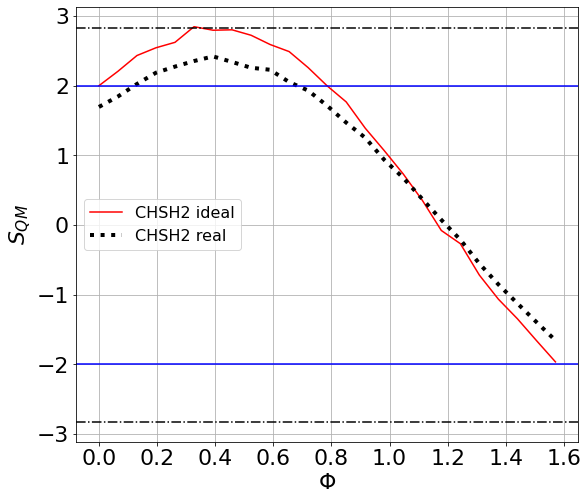

In [25]:
plt.figure(figsize=(9,8))
plt.rcParams.update({'font.size': 22})
#phi2 = np.linspace(0,np.pi/2,25)
plt.plot(phi_vec,CHSH2_ideal, color ='r',label = 'CHSH2 ideal')
plt.plot(phi_vec,CHSH2_real,color ='black',label = 'CHSH2 real', linestyle='dotted', lw = 4)

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='blue', linestyle='-')
plt.axhline(y=-2, color='blue', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Φ')
plt.ylabel('$S_{QM}$')
plt.savefig("CHSH_inequality.png")

Here we compute the maximum value of the figure in order to know at which angle Bell-CHSH inequality is violated maximally.  

In [26]:
print(np.max(CHSH2_ideal))
print(np.max(CHSH2_real))

2.84765625
2.4208984375


The error respect the ideal value $2\sqrt{2}$, is given in the following box. 

In [27]:
s = (np.abs(np.min(CHSH2_real)) - 2*np.sqrt(2))/(2*np.sqrt(2))*100
print(s)

-41.43408800841401


The circuits used to compute measurements which give us the expectation
value of the spin-correlation function are shown below. 

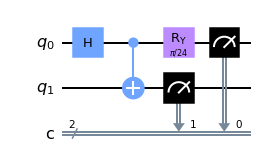

In [13]:
my_chsh_circuits[4].draw()

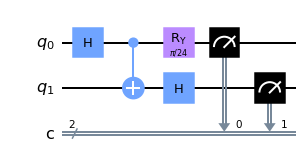

In [14]:
my_chsh_circuits[5].draw()

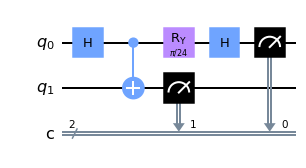

In [15]:
my_chsh_circuits[6].draw()

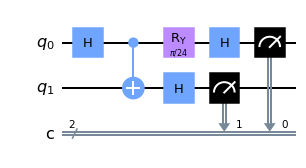

In [16]:
my_chsh_circuits[7].draw()